In [2]:
#import packages
import numpy as np
import copy
import pandas
import os
import imp
import pickle
from scipy.interpolate import interp1d
import warnings
import time
import matplotlib.pyplot as plt
import inspect
import types
import math as mat
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import datetime
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import matplotlib.backends.backend_pdf
from scipy import interpolate
from itertools import groupby
import re
import csv
import copy
from fnmatch import fnmatch
import json
import h5py 
import copy
import math
pi = math.pi

sns.set()
sns.set_style()
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#functions

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_elapsed_time(my_list):
#for list of lists
    all_t_ellapsed = []
    for i in range(len(my_list)):
        t_ellapsed = my_list[i] - my_list[i][0]
        all_t_ellapsed.append(t_ellapsed)
    return all_t_ellapsed

def smallestSignedAngleBetween(x, y):
    a = math.atan2(math.sin(y-x), math.cos(y-x))
    return a

def get_smallestSignedAngleBetween(ax, y):
    yy=np.deg2rad(np.ones(len(ax))*y)
    axx = np.deg2rad(ax)
    
    array_smallestsignedangle = []
    for k in range(len(ax)):
        kk = smallestSignedAngleBetween(axx[k], yy[k])*-1
        kk = (np.rad2deg(kk))
        array_smallestsignedangle.append(kk)
    
    return array_smallestsignedangle

def circmean(alpha,axis=None):
    mean_angle = np.arctan2(np.mean(np.sin(alpha),axis),np.mean(np.cos(alpha),axis))
    return mean_angle

def circvar(alpha,axis=None):
#### vector strength = 1 - circvar
#     if np.ma.isMaskedArray(alpha) and alpha.mask.shape!=():
#         N = np.sum(~alpha.mask,axis)
#     else:
#         if axis is None:
#             N = alpha.size
#         else:
#             N = alpha.shape[axis]
    R = np.sqrt(np.sum(np.sin(alpha),axis)**2 + np.sum(np.cos(alpha),axis)**2)/len(alpha)
    V = 1-R
    return R

In [4]:
#Notes:
#Patterns are big blobz approximately of 4px by 6px. They are dithered with 10 to 14 intensity levels (depending
#if the are moving diagonally or cardinally). 8 different patterns. Only panels are included in this experiment. 
#Everything else is off. Code for pattern is saved in blobz_ivo_0919

In [5]:
dataDir = '/Users/fponce/Documents/vdesert/VD_090319'
pattern_vdesert_data = "*.hdf5"
exp = 'VD_090319'

#pattern table used from vdesert params
#pattern_angles should correspond to pattern_ids 1 to 1
pattern_ids = [1,2,3,4,5,6,7,8]
pattern_angles = [45, 135, 90, 180, -45, 0, -90, -135]

#for magnotether angle interpolation
number_trials = 14
trial_time = int((180*number_trials/2) + (5*number_trials/2))
number_frames_per_sec = 30
print(trial_time)

1295


In [6]:
#import data
datapaths = []
for path, subdirs, files in os.walk(dataDir):
    for name in files:
        if fnmatch(name, pattern_vdesert_data):
            datapaths.append(os.path.join(path, name))
            
print(datapaths[-1])
print(len(datapaths))

#check for keys
# for i in range(len(datapaths)):
#     f = h5py.File(datapaths[i], "r")
#     datasetNames = [n for n in f.keys()]
# print(datasetNames)

/Users/fponce/Documents/vdesert/VD_090319/data/data_2019-09-05-17-00-15.hdf5
8


In [7]:
#hdf5 -> np.arrays
all_params_ts = []
all_data_params = []

all_ros_ts = []
all_ts = []
all_elapsed_time = []
all_trial_index = []
all_trial_elapsed_time = []
all_angle_for_autostep = []
all_init_angle = []
all_autostep_running = []
all_autostep_started = []
all_autostep_stopped = []
all_flow_running = []
all_flow_started = []
all_flow_stopped = []
all_panels_running = []
all_panels_started = []
all_panels_stopped = []

all_magnotether_angle = []
all_magnotether_ros_tstamps = []
all_magnotether_tstamps = []

all_motion_ros_tstamps = []
all_motion_tstamps = []
all_motion_setpoint = []
all_motion_position = []

all_ledpanels_ros_tstamps = []
all_ledpanels_command = []
all_ledpanels_1 = []
all_ledpanels_2 = []
all_ledpanels_3 = []
all_ledpanels_4 = []
all_ledpanels_5 = []
all_ledpanels_6 = []

for i in range(len(datapaths)):
    f = h5py.File(datapaths[i], "r")
    
    #parameters topic
    params_ts = np.asarray(f['data_params_ros_tstamps'])
    data_params = np.asarray(f['data_params'])
    
    #virtual_desert topic
    ros_ts = np.asarray(f['ros_tstamps'])
    ts = np.asarray(f['tstamps'])
    elapsed_time = np.asarray(f['elapsed_time'])
    trial_index = np.asarray(f['current_trial_index'])
    trial_elapsed_time = np.asarray(f['trial_e_time'])
    angle_for_autostep = np.asarray(f['angle'])
    init_angle = np.asarray(f['init_angle'])
    
    #actions
    autostep_running = np.asarray(f['autostep_action_running'])
    autostep_started = np.asarray(f['autostep_action_started'])
    autostep_stopped = np.asarray(f['autostep_action_stopped'])
    
    flow_running = np.asarray(f['flow_action_running'])
    flow_started = np.asarray(f['flow_action_started'])
    flow_stopped = np.asarray(f['flow_action_stopped'])  
    
    panels_running = np.asarray(f['panels_action_running'])
    panels_started = np.asarray(f['panels_action_started'])
    panels_stopped = np.asarray(f['panels_action_stopped'])      
    
    #magnotether_angle topic
    magnotether_angle = np.asarray(f['magnotether_angle'])
    magnotether_ros_tstamps = np.asarray(f['magnotether_ros_tstamps'])
    magnotether_tstamps = np.asarray(f['magnotether_tstamps'])
    
    #motion_data topic
    motion_ros_tstamps = np.asarray(f['motion_data_ros_tstamps'])
    motion_tstamps = np.asarray(f['motion_data_tstamps'])
    motion_setpoint = np.asarray(f['motion_data_setpoint'])
    motion_position = np.asarray(f['motion_data_position'])
    
    #ledpanels topic
    ledpanels_ros_tstamps = np.asarray(f['ledpanels_ros_tstamps'])
    ledpanels_command = np.asarray(f['ledpanels_panels_command'])
    ledpanels_1 = np.asarray(f['ledpanels_panels_arg1'])
    ledpanels_2 = np.asarray(f['ledpanels_panels_arg2'])
    ledpanels_3 = np.asarray(f['ledpanels_panels_arg3'])
    ledpanels_4 = np.asarray(f['ledpanels_panels_arg4']) 
    ledpanels_5 = np.asarray(f['ledpanels_panels_arg5']) 
    ledpanels_6 = np.asarray(f['ledpanels_panels_arg6']) 
    
    all_params_ts.append(params_ts)
    all_data_params.append(data_params)
    all_ros_ts.append(ros_ts)
    all_ts.append(ts)
    all_elapsed_time.append(elapsed_time)
    all_trial_index.append(trial_index)
    all_trial_elapsed_time.append(trial_elapsed_time)
    all_angle_for_autostep.append(angle_for_autostep)
    all_init_angle.append(init_angle)
    all_autostep_running.append(autostep_running)
    all_autostep_started.append(autostep_started)
    all_autostep_stopped.append(autostep_stopped)
    all_flow_running.append(flow_running)
    all_flow_started.append(flow_started)
    all_flow_stopped.append(flow_stopped)
    all_panels_running.append(panels_running)
    all_panels_started.append(panels_started)
    all_panels_stopped.append(panels_stopped)
    all_magnotether_angle.append(magnotether_angle)
    all_magnotether_ros_tstamps.append(magnotether_ros_tstamps)
    all_magnotether_tstamps.append(magnotether_tstamps)
    all_motion_ros_tstamps.append(motion_ros_tstamps)
    all_motion_tstamps.append(motion_tstamps)
    all_motion_setpoint.append(motion_setpoint)
    all_motion_position.append(motion_position)
    all_ledpanels_1.append(ledpanels_1)
    all_ledpanels_2.append(ledpanels_2)
    all_ledpanels_3.append(ledpanels_3)
    all_ledpanels_4.append(ledpanels_4)
    all_ledpanels_5.append(ledpanels_5)
    all_ledpanels_6.append(ledpanels_6)
    all_ledpanels_command.append(ledpanels_command)
    all_ledpanels_ros_tstamps.append(ledpanels_ros_tstamps)

In [8]:
# #quick look data
# for i in range(len(all_magnotether_angle)):
#     plt.figure()
#     plt.plot(all_magnotether_angle[i])
#     plt.title(datapaths[i])

In [9]:
#get ledpanels info

#gets the indeces of the set pattern id command
all_idx_pat_command = []
all_idx_gain_command = []
for i in range(len(datapaths)):
    idx_pat_command = [i for i, x in enumerate(all_ledpanels_command[i])
               if x == b'set_pattern_id']
    idx_gain_command = [i for i, x in enumerate(all_ledpanels_command[i])
               if x == b'send_gain_bias']
    all_idx_pat_command.append(idx_pat_command)
    all_idx_gain_command.append(idx_gain_command)

#get elapsed time of panels
all_ledpanels_elapsed_t = get_elapsed_time(all_ledpanels_ros_tstamps)

#get the timestamp and elapsed time of the set pattern id command
all_ros_tstamps_pat_id = []
all_ledpanels_elapsed_t_pat_id  = []
for i in range(len(all_idx_pat_command)):
    ros_tstamps_pat_id_file = []
    ledpanels_elapsed_t_pat_id_file = []
    for j in (all_idx_pat_command[i]):
        ros_tstamps_pat_id = all_ledpanels_ros_tstamps[i][j]
        ledpanels_elapsed_t_pat_id = all_ledpanels_elapsed_t[i][j]
        
        ros_tstamps_pat_id_file.append(ros_tstamps_pat_id)
        ledpanels_elapsed_t_pat_id_file.append(ledpanels_elapsed_t_pat_id)
        
    all_ros_tstamps_pat_id.append(ros_tstamps_pat_id_file)
    all_ledpanels_elapsed_t_pat_id.append(ledpanels_elapsed_t_pat_id_file) 
    
#get arg1 for pannel_id command and gains
#get the arg1 for the rows of pattern_id command
all_pattern_id = []
for i in range(len(all_idx_pat_command)):
    pattern_id_file = []
    for j in (all_idx_pat_command[i]):
        arg1 = all_ledpanels_1[i][j]
        pattern_id_file.append(arg1)
    all_pattern_id.append(pattern_id_file)
    
#get the arg1 for the rows of gain command
all_gains = []
for i in range(len(all_idx_gain_command)):
    gains_file = []
    for j in (all_idx_gain_command[i]):
        arg1 = all_ledpanels_1[i][j]
        gains_file.append(arg1)
    all_gains.append(gains_file)
    
# print(all_ledpanels_elapsed_t_pat_id[0])
# print(all_pattern_id[0])
print(all_gains[0])

[80, 0, 10, 0, 1, 0, 20, 0, 0, 0, 40, 0, 5, 0]


In [10]:
#interpolation of magnotether angles

t = [0,trial_time]
print(trial_time*number_frames_per_sec)
reg_t = np.linspace(t[0], t[-1],(trial_time*number_frames_per_sec)+1)

#getting elapsed time of time stamps to use
all_ts = get_elapsed_time(all_magnotether_ros_tstamps)

#making the interpolation
all_magnotether_interp_angles = []
for i in range(len(datapaths)):       
    mysecs_np = all_ts[i]
    myangles_np = all_magnotether_angle[i]    
    f_a = interp1d(mysecs_np, myangles_np, bounds_error=False)
    reg_a = f_a(reg_t)
    all_magnotether_interp_angles.append(reg_a)

38850


In [11]:
#this gets the times(all_elapsed_time) when the trial changes in the virtual desert node

all_start_times = []
all_end_times = []
for i in range(len(datapaths)):
    start_times_trials = []
    end_times_trials = []
    for j in range(number_trials):
        start_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][0]
        end_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][-1]
        start_times_trials.append(start_time)
        end_times_trials.append(end_time)
    all_start_times.append(start_times_trials)
    all_end_times.append(end_times_trials)
    
# print(all_start_times[0])
# print(all_end_times[0])

all_start_frames = []
all_end_frames = []
for i in range(len(datapaths)):
    start_frames_trials = []
    end_frames_trials = []
    for j in range((number_trials)):
        start_frame = [np.where(all_trial_index[i]==j)][0][0][0]
        end_frame = [np.where(all_trial_index[i]==j)][0][0][-1]
        start_frames_trials.append(start_frame)
        end_frames_trials.append(end_frame)
    all_start_frames.append(start_frames_trials)
    all_end_frames.append(end_frames_trials)
# print(all_start_frames[0])
# print(all_end_frames[0])

#get the closest times that correspond to start and end times in the reg_t
all_magnotether_elapsed = reg_t

all_start_times_m = []    
all_end_times_m = []   
for i in range(len(all_start_times)): 
    start_times_trials_m = []
    end_times_trials_m = []    
    for j in range((number_trials)):
        start_times_m = find_nearest(all_magnotether_elapsed, all_start_times[i][j])
        end_times_m = find_nearest(all_magnotether_elapsed, all_end_times[i][j])
        start_times_trials_m.append(start_times_m)
        end_times_trials_m.append(end_times_m)
    all_start_times_m.append(start_times_trials_m)    
    all_end_times_m.append(end_times_trials_m)     
    
# print(all_start_times_m[0])   
# print(all_end_times_m[0])   

all_start_frames_m = []    
all_end_frames_m = []   
for i in range(len(all_start_times)): 
    start_frames_trials_m = []
    end_frames_trials_m = []    
    for j in range((number_trials)):
        start_frames_m = find_nearest_idx(all_magnotether_elapsed, all_start_times[i][j])
        end_frames_m = find_nearest_idx(all_magnotether_elapsed, all_end_times[i][j])
        start_frames_trials_m.append(start_frames_m)
        end_frames_trials_m.append(end_frames_m)
    all_start_frames_m.append(start_frames_trials_m)    
    all_end_frames_m.append(end_frames_trials_m)     
    
# print(all_start_frames_m[0])   
# print(all_end_frames_m[0]) 

In [12]:
# map pattern_ids with angles in lab corrdinates

all_pat_angles = []
for i in range(len(all_pattern_id)):
    pat_angles_file = []
    for j in range(len(all_pattern_id[i])):
        if   all_pattern_id[i][j] == pattern_ids[0]:
            p = pattern_angles[0]
        elif all_pattern_id[i][j] == pattern_ids[1]:
            p = pattern_angles[1]
        elif all_pattern_id[i][j] == pattern_ids[2]:
            p = pattern_angles[2]
        elif all_pattern_id[i][j] == pattern_ids[3]:
            p = pattern_angles[3]
        elif all_pattern_id[i][j] == pattern_ids[4]:
            p = pattern_angles[4]
        elif all_pattern_id[i][j] == pattern_ids[5]:
            p = pattern_angles[5]
        elif all_pattern_id[i][j] == pattern_ids[6]:
            p = pattern_angles[6]
        elif all_pattern_id[i][j] == pattern_ids[7]:
            p = pattern_angles[7]
        else:
            print('SOMETHING IS WRONG')
        pat_angles_file.append(p)
    all_pat_angles.append(pat_angles_file)
# print(all_pat_angles[0])

In [13]:
# plot and save raw data
#allangles = all_magnotether_interp_angles

# plot and save raw data
# for i in [0]: 
#     # #plot raw normed data
#     fig, axs = plt.subplots(figsize=(30, 70), facecolor='w', edgecolor='k')
#     #fig.subplots_adjust(hspace = .2, wspace=.09, bottom=0.1)
#     #fig.tight_layout()
#     fig.suptitle('Experiment '+exp+'\n'+'raw data '+'Fly '+str(i),fontsize = 30, fontweight='bold')
#     fig.subplots_adjust(top=0.96, hspace = .4, bottom=0.05)
    
#     bckclr_labels = ['lavender']
    
#     gs = gridspec.GridSpec(7, 1)
    
#     ######################################################################################################
    
#     #trial 1 + 5 sec of static pattern
#     j = 0
#     ax1 = plt.subplot(gs[0, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     c = all_end_frames_m[i][j+1]
#     ang_to_plot = allangles[i][a:c] 
    
#     ax1.plot(reg_t[a:c],ang_to_plot,color = 'k')
#     ax1.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax1.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax1.set_ylim([-200, 200])
#     ax1.set_xlim([reg_t[a], reg_t[c]])
#     #ax1.set_xticks(np.arange(all_start_frames[j], all_end_frames[j+1], 10798))
#     ax1.set_yticks(np.arange(-180, 225,45))
#     ax1.yaxis.set_tick_params(labelsize=30)
#     ax1.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax1.patch.set_facecolor(bckclr_labels[0])
#     plt.axvspan(reg_t[b], reg_t[c], facecolor='0.2', alpha=0.3)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax1.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax1.spines['left'].set_smart_bounds(True)
#     ax1.spines['bottom'].set_smart_bounds(True)
#     ax1.spines['left'].set_linewidth(2)
#     ax1.spines['bottom'].set_linewidth(2)
#     ax1.grid(True,linewidth=2)
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 2
#     ax2 = plt.subplot(gs[j-1, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     c = all_end_frames_m[i][j+1]
#     ang_to_plot = allangles[i][a:c] 
    
#     ax2.plot(reg_t[a:c],ang_to_plot,color = 'k')
#     ax2.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     plt.axvspan(reg_t[b], reg_t[c], facecolor='0.2', alpha=0.3)
#     #plot format
#     ax2.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax2.set_ylim([-200, 200])
#     ax2.set_xlim([reg_t[a], reg_t[c]])
#     #ax1.set_xticks(np.arange(all_start_frames[j], all_end_frames[j+1], 10798))
#     ax2.set_yticks(np.arange(-180, 225,45))
#     ax2.yaxis.set_tick_params(labelsize=30)
#     ax2.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax2.patch.set_facecolor(bckclr_labels[0])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax2.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax2.spines['left'].set_smart_bounds(True)
#     ax2.spines['bottom'].set_smart_bounds(True)
#     ax2.spines['left'].set_linewidth(2)
#     ax2.spines['bottom'].set_linewidth(2)
#     ax2.grid(True,linewidth=2) 
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 4
#     ax3 = plt.subplot(gs[j-2, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     c = all_end_frames_m[i][j+1]
#     ang_to_plot = allangles[i][a:c] 
    
#     ax3.plot(reg_t[a:c],ang_to_plot,color = 'k')
#     ax3.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     plt.axvspan(reg_t[b], reg_t[c], facecolor='0.2', alpha=0.3)
#     #plot format
#     ax3.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax3.set_ylim([-200, 200])
#     ax3.set_xlim([reg_t[a], reg_t[c]])
#     #ax1.set_xticks(np.arange(all_start_frames[j], all_end_frames[j+1], 10798))
#     ax3.set_yticks(np.arange(-180, 225,45))
#     ax3.yaxis.set_tick_params(labelsize=30)
#     ax3.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax3.patch.set_facecolor(bckclr_labels[0])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax3.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax3.spines['left'].set_smart_bounds(True)
#     ax3.spines['bottom'].set_smart_bounds(True)
#     ax3.spines['left'].set_linewidth(2)
#     ax3.spines['bottom'].set_linewidth(2)
#     ax3.grid(True,linewidth=2)
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 6
#     ax4 = plt.subplot(gs[j-3, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     c = all_end_frames_m[i][j+1]
#     ang_to_plot = allangles[i][a:c] 
    
#     ax4.plot(reg_t[a:c],ang_to_plot,color = 'k')
#     ax4.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     plt.axvspan(reg_t[b], reg_t[c], facecolor='0.2', alpha=0.3)
#     #plot format
#     ax4.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax4.set_ylim([-200, 200])
#     ax4.set_xlim([reg_t[a], reg_t[c]])
#     #ax1.set_xticks(np.arange(all_start_frames[j], all_end_frames[j+1], 10798))
#     ax4.set_yticks(np.arange(-180, 225,45))
#     ax4.yaxis.set_tick_params(labelsize=30)
#     ax4.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax4.patch.set_facecolor(bckclr_labels[0])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax4.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax4.spines['left'].set_smart_bounds(True)
#     ax4.spines['bottom'].set_smart_bounds(True)
#     ax4.spines['left'].set_linewidth(2)
#     ax4.spines['bottom'].set_linewidth(2)
#     ax4.grid(True,linewidth=2)
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 8
#     ax5 = plt.subplot(gs[j-4, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     c = all_end_frames_m[i][j+1]
#     ang_to_plot = allangles[i][a:c] 
    
#     ax5.plot(reg_t[a:c],ang_to_plot,color = 'k')
#     ax5.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     plt.axvspan(reg_t[b], reg_t[c], facecolor='0.2', alpha=0.3)
#     #plot format
#     ax5.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax5.set_ylim([-200, 200])
#     ax5.set_xlim([reg_t[a], reg_t[c]])
#     #ax1.set_xticks(np.arange(all_start_frames[j], all_end_frames[j+1], 10798))
#     ax5.set_yticks(np.arange(-180, 225,45))
#     ax5.yaxis.set_tick_params(labelsize=30)
#     ax5.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax5.patch.set_facecolor(bckclr_labels[0])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax5.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax5.spines['left'].set_smart_bounds(True)
#     ax5.spines['bottom'].set_smart_bounds(True)
#     ax5.spines['left'].set_linewidth(2)
#     ax5.spines['bottom'].set_linewidth(2)
#     ax5.grid(True,linewidth=2)
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 10
#     ax6 = plt.subplot(gs[j-5, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     c = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:c] 
    
#     ax6.plot(reg_t[a:c],ang_to_plot,color = 'k')
#     ax6.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plt.axvspan(reg_t[b], reg_t[c], facecolor='0.2', alpha=0.3)
#     #plot format
#     ax6.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax6.set_ylim([-200, 200])
#     ax6.set_xlim([reg_t[a], reg_t[c]])
#     #ax1.set_xticks(np.arange(all_start_frames[j], all_end_frames[j+1], 10798))
#     ax6.set_yticks(np.arange(-180, 225,45))
#     ax6.yaxis.set_tick_params(labelsize=30)
#     ax6.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax6.patch.set_facecolor(bckclr_labels[0])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax6.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax6.spines['left'].set_smart_bounds(True)
#     ax6.spines['bottom'].set_smart_bounds(True)
#     ax6.spines['left'].set_linewidth(2)
#     ax6.spines['bottom'].set_linewidth(2)
#     ax6.grid(True,linewidth=2)
    
#     ######################################################################################################
    
#     # trial 2 + 5 sec of static pattern
#     j = 12
#     ax7 = plt.subplot(gs[j-6, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     c = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:c] 
    
#     ax7.plot(reg_t[a:c],ang_to_plot,color = 'k')
#     ax7.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plt.axvspan(reg_t[b], reg_t[c], facecolor='0.2', alpha=0.3)
#     #plot format
#     ax7.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax7.set_ylim([-200, 200])
#     ax7.set_xlim([reg_t[a], reg_t[c]])
#     #ax1.set_xticks(np.arange(all_start_frames[j], all_end_frames[j+1], 10798))
#     ax7.set_yticks(np.arange(-180, 225,45))
#     ax7.yaxis.set_tick_params(labelsize=30)
#     ax7.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax7.patch.set_facecolor(bckclr_labels[0])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax7.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax7.spines['left'].set_smart_bounds(True)
#     ax7.spines['bottom'].set_smart_bounds(True)
#     ax7.spines['left'].set_linewidth(2)
#     ax7.spines['bottom'].set_linewidth(2)
#     ax7.grid(True,linewidth=2)
#     ax7.set_xlabel('Time (s)', fontsize=30)
    
# #    savefigdir = '/Users/fponce/Documents/vdesert/VD_090319/'
#  #   fig.savefig(savefigdir+exp+'_rawdata_'+'Fly_'+str(i)+'.pdf')  #bbox_inches='tight'

In [14]:
# zero the angle/normalize
allangles = all_magnotether_interp_angles
allangles_vf = copy.deepcopy(allangles)

for i in range(len(allangles_vf)):
    for j in range(len(all_start_frames_m[i])):
        allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]] = get_smallestSignedAngleBetween(\
        allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]], all_pat_angles[i][j])

In [15]:
test_trials_idx = [0,2,4,6,8,10,12]
test_gains = [0,1,5,10,20,40,80]

all_trial_gains = []
for i in range(len(all_gains)):
    trial_gains = [ all_gains[i][k] for k in test_trials_idx]
    all_trial_gains.append(trial_gains)

In [16]:
print(all_trial_gains[0])

[80, 10, 1, 20, 0, 40, 5]


In [17]:
all_start_frames_sort = []
all_end_frames_sort = []
for i in range(len(all_gains)):
    start_frames_sort = []
    end_frames_sort = []
    for j in test_gains:
        sorted_gains_idx = np.where(np.asarray(all_trial_gains[i]) == j)[0][0]*2 #times 2 to find the idx in all_gains
        sf = np.asarray(all_start_frames_m[i])[sorted_gains_idx]
        ef = np.asarray(all_end_frames_m[i])[sorted_gains_idx]
        start_frames_sort.append(sf)
        end_frames_sort.append(ef)
    all_start_frames_sort.append(start_frames_sort)
    all_end_frames_sort.append(end_frames_sort)
print(all_start_frames_sort[0])

[22225, 11119, 33331, 5566, 16672, 27778, 14]


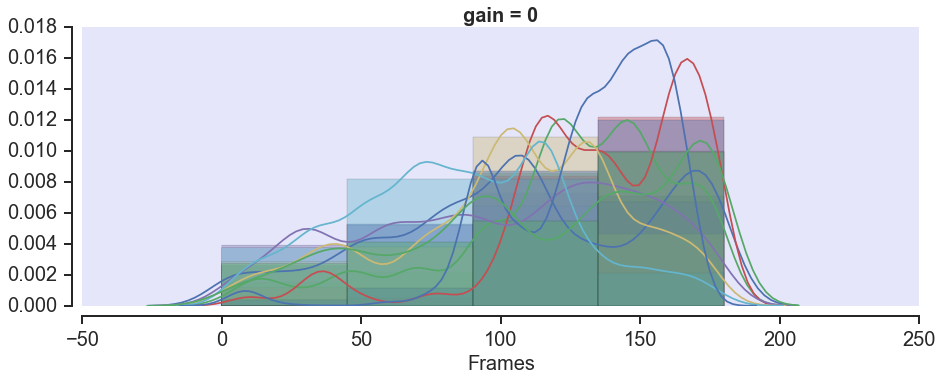

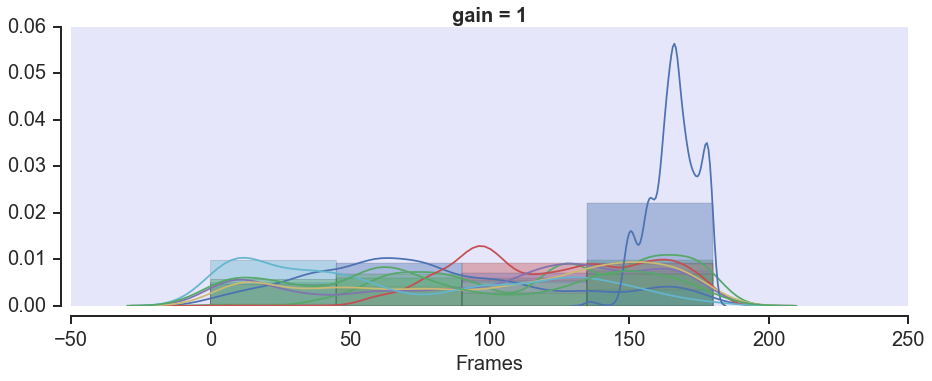

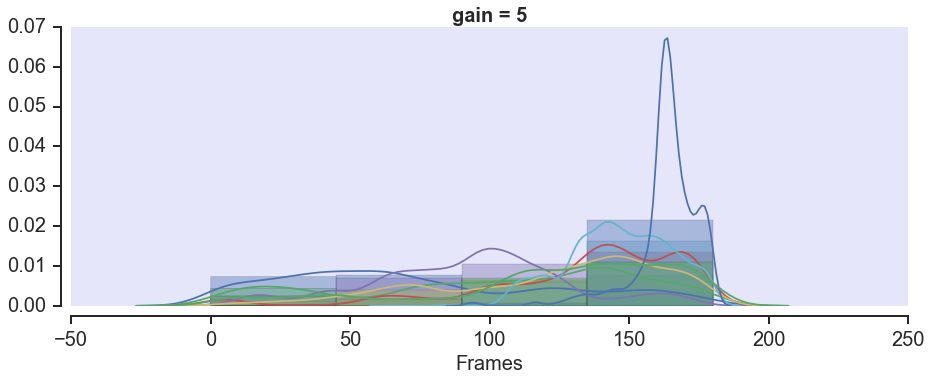

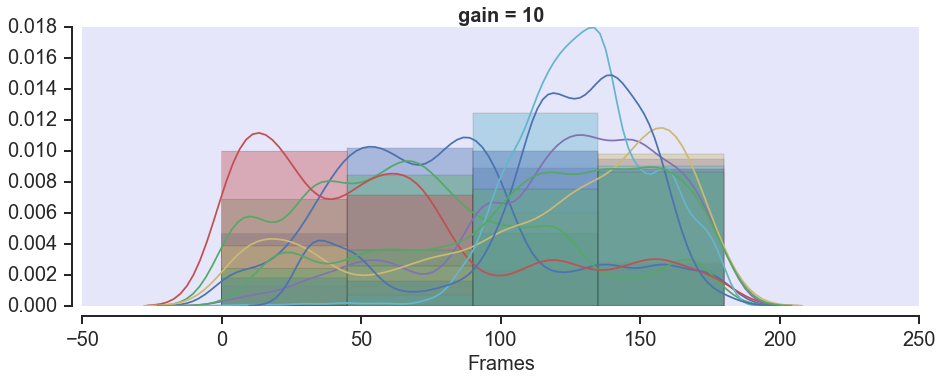

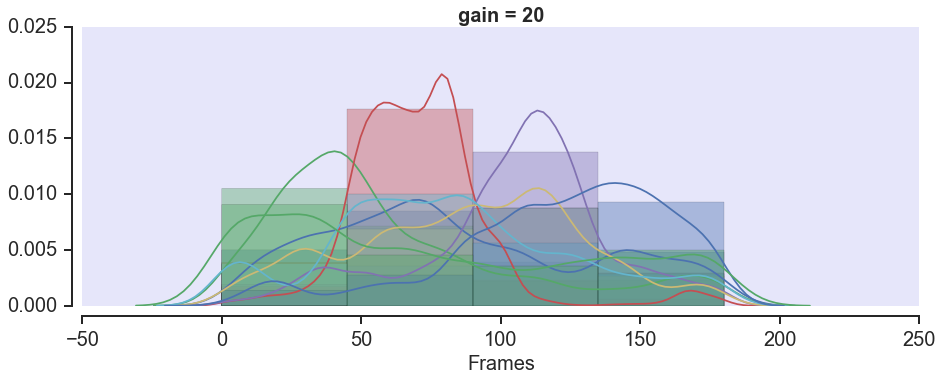

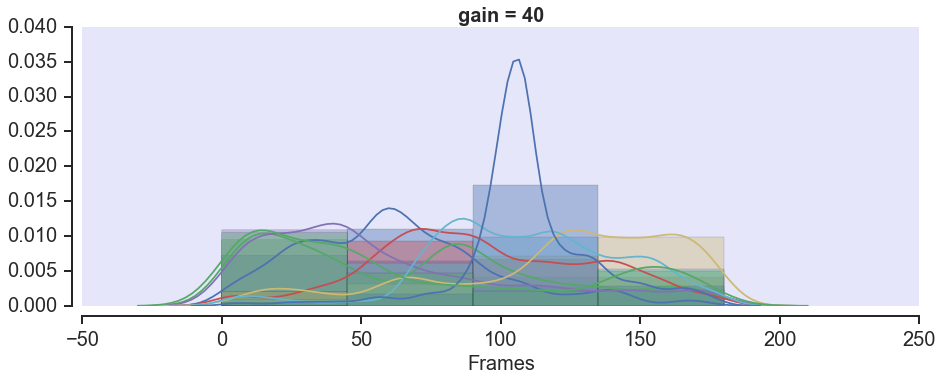

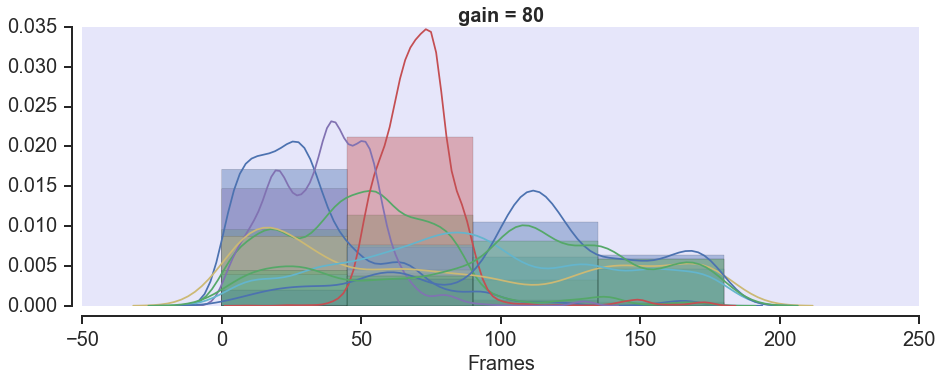

In [18]:
#density plots
sns.set_style("ticks")
for j in [0,1,2,3,4,5,6]:    
    fig, ax1 = plt.subplots(1,1,figsize=(15, 5))    
    for i in range(len(allangles_vf)):
        
#         k = sns.distplot(allangles_vf[i][all_start_frames_sort[i][j]:all_end_frames_sort[i][j]],\
#                      bins=18, hist=True)
        
        k = sns.distplot(np.abs(allangles_vf[i][all_start_frames_sort[i][j]:all_end_frames_sort[i][j]]),\
                     bins=[ 0, 45, 90, 135, 180], hist=True, norm_hist=True)
        
        ax1.patch.set_facecolor('lavender')
        sns.set_style("ticks")
        sns.despine()
        ax1.autoscale()
        ax1.set_title('gain = '+str(test_gains[j]),fontsize = 20, fontweight='bold')
       #plt.ylim(0, None)
        #plt.ylim(0, 0.025)
        ax1.tick_params(direction='out', length=8, width=2)
        sns.despine(offset=10, trim=False);
        ax1.spines['left'].set_smart_bounds(True)
        ax1.spines['bottom'].set_smart_bounds(True)
        ax1.spines['left'].set_linewidth(2)
        ax1.spines['bottom'].set_linewidth(2)
        #ax1.grid(False,linewidth=2)
        ax1.yaxis.set_tick_params(labelsize=20)
        ax1.xaxis.set_tick_params(labelsize=20)
        ax1.set_xlabel('Frames', fontsize=20)
#         ax1.set_title('gain = '+str(test_gains[j]),fontsize = 20, fontweight='bold')
        #plt.hist(allangles_vf[i][all_start_frames_sort[i][j]:all_end_frames_sort[i][j]],  alpha = 0.5,\
               # bins=[-180, -135, -90, -45, 0, 45, 90, 135, 180], normed=True, color='steelblue')
        
        savefigdir = '/Users/fponce/Documents/vdesert/VD_090319/'
        fig.savefig(savefigdir+exp+'_density_'+str(j)+'.pdf')  #bbox_inches='tight'

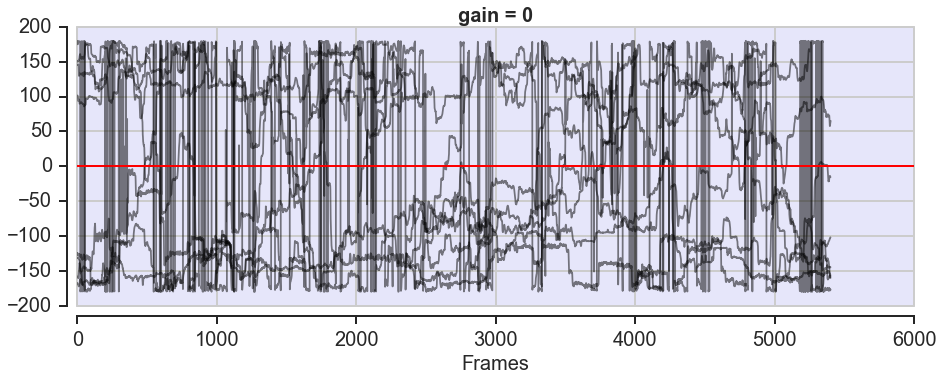

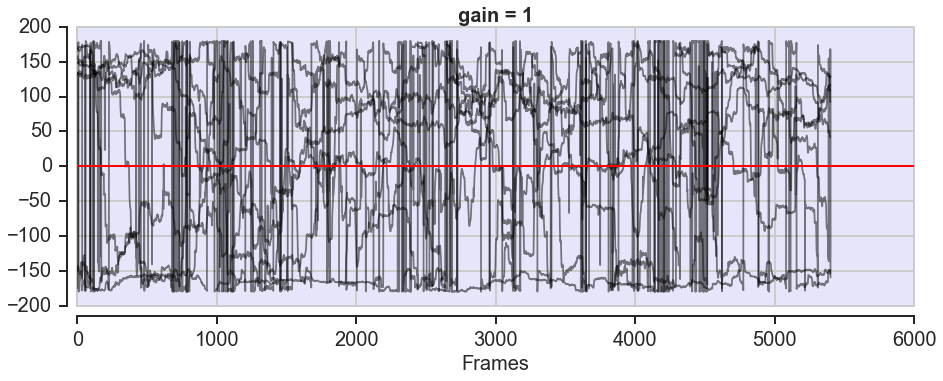

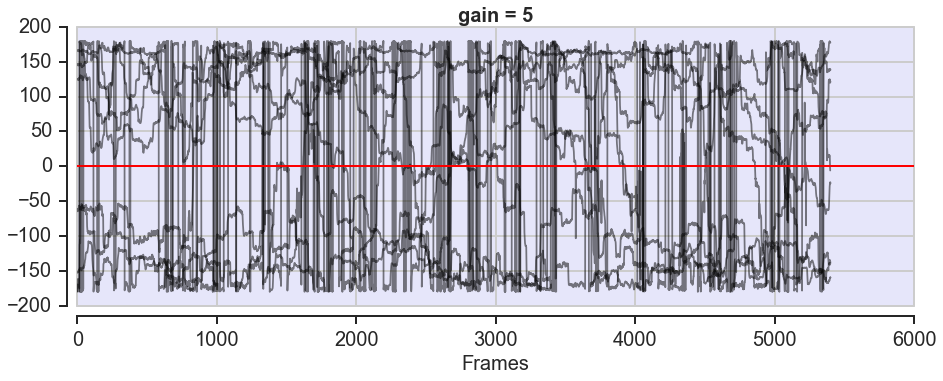

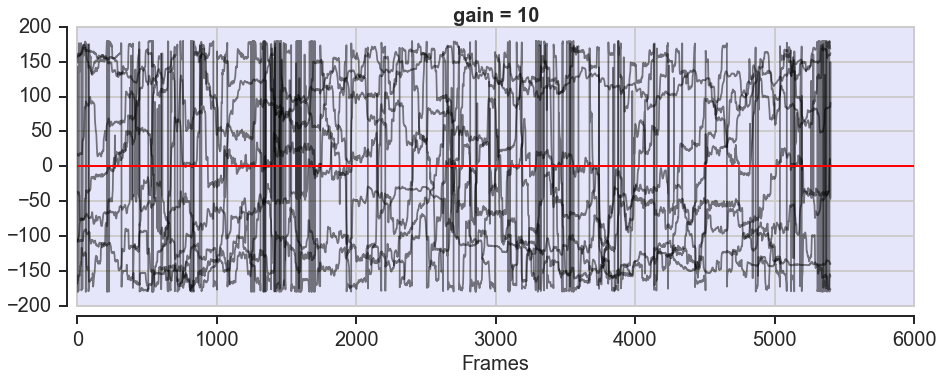

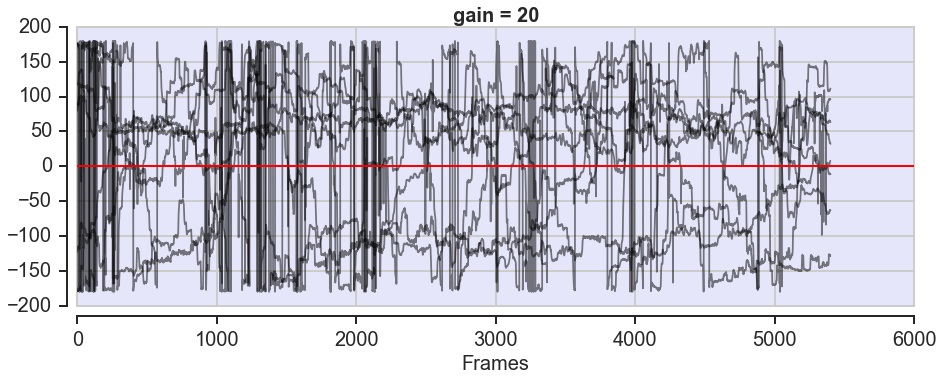

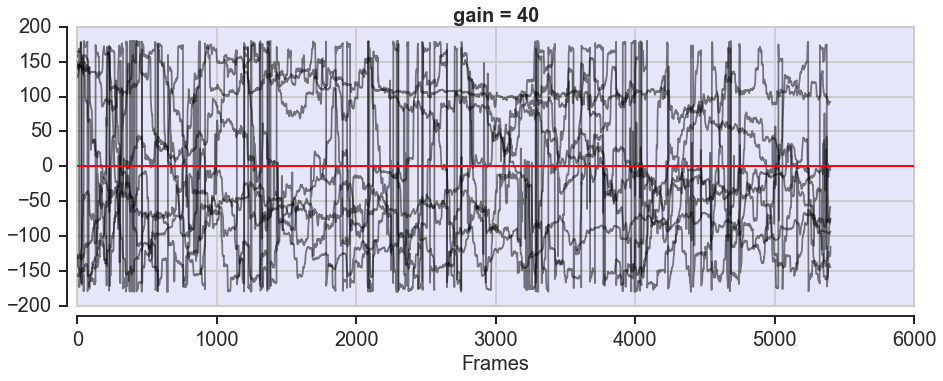

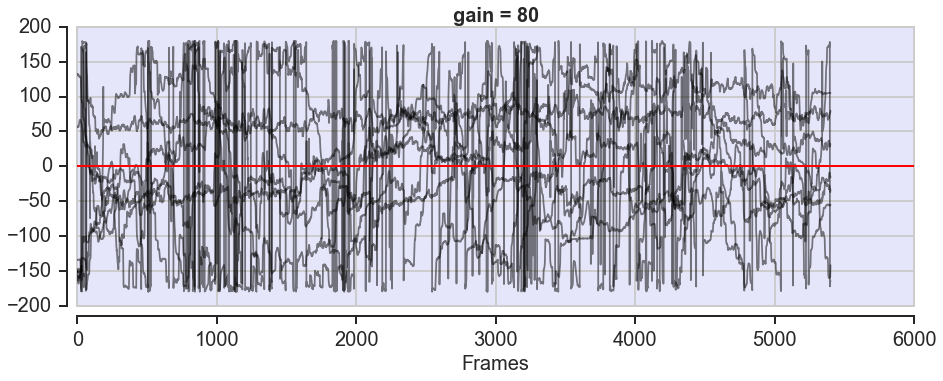

In [19]:
sns.set_style("ticks")
for j in [0,1,2,3,4,5,6]:    
    fig, ax1 = plt.subplots(1,1,figsize=(15, 5))    
    for i in range(len(allangles_vf)):
        
        plt.plot(
                allangles_vf[i][all_start_frames_sort[i][j]:all_end_frames_sort[i][j]],\
                color = 'k', alpha = 0.5)
        
#         plt.plot(reg_t[all_start_frames_sort[i][j]:all_end_frames_sort[i][j]],\
#                 allangles_vf[i][all_start_frames_sort[i][j]:all_end_frames_sort[i][j]],\
#                 color = 'k', alpha = 0.5)
        
        plt.axhline(y = 0, color = 'r')
        
        #plt.xlim(reg_t[all_start_frames_sort[i][j]],reg_t[all_end_frames_sort[i][j]])
        plt.ylim(-200, 200)
        
        ax1.patch.set_facecolor('lavender')
        sns.set_style("ticks")
        sns.despine()
        ax1.tick_params(direction='out', length=8, width=2)
        sns.despine(offset=10, trim=False);
        ax1.spines['left'].set_smart_bounds(True)
        ax1.spines['bottom'].set_smart_bounds(True)
        ax1.spines['left'].set_linewidth(2)
        ax1.spines['bottom'].set_linewidth(2)
        ax1.grid(True,linewidth=2)
        ax1.yaxis.set_tick_params(labelsize=20)
        ax1.xaxis.set_tick_params(labelsize=20)
        ax1.set_xlabel('Frames', fontsize=20)
        ax1.set_title('gain = '+str(test_gains[j]),fontsize = 20, fontweight='bold')
        
#         savefigdir = '/Users/fponce/Documents/vdesert/VD_090319/'
#         fig.savefig(savefigdir+exp+'_normdata_'+str(j)+'.pdf')  #bbox_inches='tight'

In [72]:
#get circular means in vf reference frame
all_circmeans_vf = []
all_circmeans_deg_vf = []
all_circvars_vf = []
for i in range(len(allangles_vf)):
    circmeans_vf = []
    circmeans_deg_vf = []
    circvars_vf = []
    for j in range(len(all_start_frames_sort[i])):
        angles_rad_vf = np.deg2rad(allangles_vf[i][all_start_frames_sort[i][j]:all_end_frames_sort[i][j]])
        
        circmeann_vf = circmean(angles_rad_vf)
        circvarr_vf = circvar(angles_rad_vf)
        circmeann_deg_vf = np.rad2deg(circmeann_vf)
        
        circmeans_vf.append((circmeann_vf))
        circmeans_deg_vf.append((circmeann_deg_vf))
        circvars_vf.append((circvarr_vf))
        
    all_circmeans_deg_vf.append(circmeans_deg_vf)
    all_circmeans_vf.append(circmeans_vf)
    all_circvars_vf.append(circvars_vf)

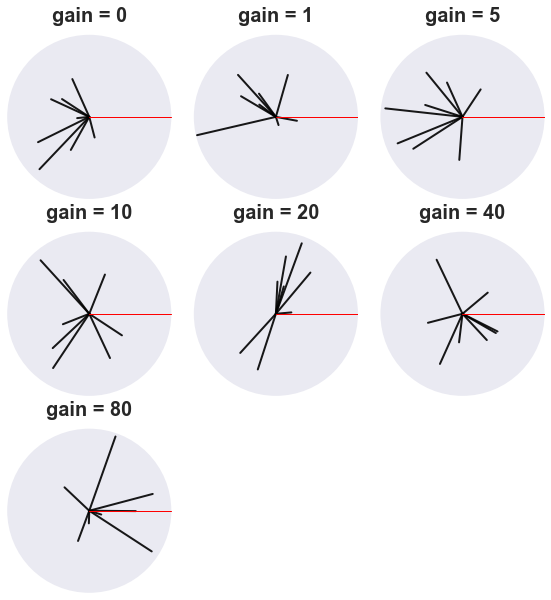

In [101]:
# circular means plot
sns.set_style('dark')
fig, axs = plt.subplots(3,3, figsize=(10, 10), facecolor='w', edgecolor='k', subplot_kw=dict(polar=True))
fig.subplots_adjust(hspace = .2, wspace=.01)
#fig.suptitle('Experiment '+exp+'\n'+'vf at zero',fontsize = 20, fontweight='bold')

axs = axs.ravel()
axisorder = [0,1,2,3,4,5,6]
g = [0,1,5,10,20,40,80]
for j in axisorder:
    for i in range(len(all_circmeans_vf)):
        cms = all_circmeans_vf[i][j]
        cvs = all_circvars_vf[i][j]
        axs[axisorder[j]].plot((0, cms), ( 0, cvs), alpha = 0.9, color = 'k', linewidth =2)#, s = 30, alpha = 0.9, color = 'k')
        axs[axisorder[j]].plot((0, 0), ( 0, 1), alpha = 0.9, color = 'r', linewidth =1)
        #axs[axisorder[j]].arrow(0,0,cms, cvs, color = 'k', alpha = 1, width = 0.000005,edgecolor = 'black', facecolor = 'k', lw = 2)
        axs[axisorder[j]].grid(False)
        axs[axisorder[j]].set_yticks([])
        axs[axisorder[j]].set_xticks([])
        axs[axisorder[j]].spines['polar'].set_visible(False)
        axs[axisorder[j]].set_rlim(0,1) 
        axs[axisorder[j]].set_title('gain = '+str(g[j]),fontsize = 20, fontweight='bold')
        #axs[axisorder[j]].patch.set_facecolor(bckclr_labels[j])
        axs[axisorder[j]].xaxis.set_tick_params(labelsize=15)

axs[7].grid(False)
axs[7].set_yticks([])
axs[7].set_xticks([])
axs[7].spines['polar'].set_visible(False)
axs[7].set_rlim(0,1) 
axs[7].patch.set_facecolor('white')
axs[7].xaxis.set_tick_params(labelsize=15)

axs[8].grid(False)
axs[8].set_yticks([])
axs[8].set_xticks([])
axs[8].spines['polar'].set_visible(False)
axs[8].set_rlim(0,1) 
axs[8].patch.set_facecolor('white')
axs[8].xaxis.set_tick_params(labelsize=15)

savefigdir = '/Users/fponce/Documents/vdesert/VD_090319/'
fig.savefig(savefigdir+exp+'_cicmeans_'+str(j)+'.pdf')  #bbox_inches='tight'